Forested Protected Lands
===

This notebook overlays the DRWI protected lands and WeConservePA protected lands with the 2019 NLCD land use data using the ModelMyWatershed api. 

The goal of this notebook is to identify whether protected lands overlap with forested areas.

# Setup

## Imports

In [1]:
# Import packages
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from modelmw_client import *
from shapely.validation import make_valid


# Plotting packages
import matplotlib
import matplotlib.pyplot as plt
from  matplotlib.colors import LogNorm
import contextily as ctx
import colorcet as cc
from colorcet.plotting import swatch, swatches, sine_combs
import holoviews as hv

In [2]:
# Look at swatches
# hv.extension("matplotlib")
#swatches()

# CET_D3, CET_CBTL4, diverging_gkr_60_10_c40

## File paths

In [3]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment/stage2/Protected_Lands')

In [4]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent.parent
project_path

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment')

In [5]:
# Path to WeConservePA protected lands shapefile
wcpa_path = project_path / Path('stage2/Protected_Lands/WeConservePA_pl_20220810.shp')
wcpa_path.exists()

True

## Private file paths
- Download from https://drive.google.com/drive/folders/1HKlnA3lC2xvKBQ1bg1J08gsEB3N9rp2V
- Save in `stage2/private` folder

In [6]:
# Path to FieldDoc protected lands export file
fielddoc_path = project_path / Path('stage2/private/protection_bmps_from_FieldDoc.parquet')
fielddoc_path.exists()

True

# Load data

## Protected Lands from WeConservePA

In [7]:
# Import weconservePA protected lands
wcpa_gdf = gpd.read_file(wcpa_path)

In [8]:
# Add data source tag
wcpa_gdf['data_source'] = 'weconservePA_2022'

## Protected Lands from FieldDoc

In [9]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet(fielddoc_path)

# Add a column to fielddoc_gdf with data source
fielddoc_gdf['data_source'] = 'fielddoc_2022-08-11'

fielddoc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   practice_name  75 non-null     object  
 1   practice_id    75 non-null     int64   
 2   program_name   75 non-null     object  
 3   program_id     75 non-null     int64   
 4   organization   75 non-null     object  
 5   description    26 non-null     object  
 6   practice_type  75 non-null     object  
 7   created_at     75 non-null     object  
 8   modified_at    75 non-null     object  
 9   tot_pwr        75 non-null     float64 
 10  head_pwr       75 non-null     float64 
 11  nat_land       75 non-null     float64 
 12  ara_pwr        75 non-null     float64 
 13  wet_pwr        75 non-null     float64 
 14  dev_land       75 non-null     float64 
 15  ag_land        75 non-null     float64 
 16  str_bank       75 non-null     float64 
 17  geometry       75 non-null   

## DRWI Geographies

In [10]:
# Import cluster and focus area geometries
cluster_gdf = gpd.read_parquet(project_path / Path('stage1/data/cluster_df.parquet'))  
focusarea_gdf = gpd.read_parquet(project_path / Path('stage1/data/fa_phase2_df.parquet'))

focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

# Plotting FXNS Carried Over from PlottingFunctions.py

Could not get these to import from the actual .py file, so the necessary functions are copied in below.

In [11]:
class MidPointLogNorm(LogNorm):
    '''
    Centers longscale colorbar around provided value
    Created using: https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
    '''
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))
    
def FormatAxes(ax, bounds=[-8.56 * 10**6,  -8.17 * 10**6, 4.65* 10**6, 5.26 * 10**6]):
    '''
    Format map axes
    Default is the full extent of the DRB
    '''
    ax.set_xlim(bounds[0], bounds[1])
    ax.set_ylim(bounds[2], bounds[3])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
def LatLonExtent_FA(fa_list, focusarea_gdf):
    '''
    Get lat and lon extent of a foucs area 
    '''
    mn_x = np.inf
    mx_x = -np.inf
    mn_y = np.inf
    mx_y = -np.inf

    for fa in fa_list:
        values = focusarea_gdf[focusarea_gdf.index==fa].geometry.bounds
        try:
            mn_x = min(mn_x, values.minx[0])
            mx_x = max(mx_x, values.maxx[0])
            mn_y = min(mn_y, values.miny[0])
            mx_y = max(mx_y, values.maxy[0])
        except:
            pass
        
    y_extent = (mx_y - mn_y)
    x_extent = (mx_x - mn_x)


    # add 5 percent cushion
    x_cushion = x_extent * 0.05
    y_cushion = y_extent * 0.05

    aspect = 1 # (5.26 * 10**6 - 4.65* 10**6)/ (8.56 * 10**6 - 8.17 * 10**6)
    base_aspect = (y_extent + y_cushion) / (x_extent + x_cushion)


    if base_aspect > aspect:
        lat_max = mx_y + y_cushion
        lat_min = mn_y - y_cushion

        x_tot = (y_extent + 2*y_cushion) / aspect 
        x_pad = (x_tot - x_extent) / 2
        
        lon_max = mx_x + x_pad
        lon_min = mn_x - x_pad
        
        h_v = "vertical"

    elif base_aspect < aspect:
        lon_max = mx_x + x_cushion
        lon_min = mn_x - x_cushion 

        y_tot = (x_extent + 2*x_cushion) * aspect
        y_pad = (y_tot - y_extent) / 2

        lat_max = mx_y + y_pad
        lat_min = mn_y - y_pad

        h_v = "horizontal"

    else:
        lon_max = mx_x + x_extent
        lon_min = mn_x - x_extent
        lat_max = mx_y + y_extent
        lat_min = mn_y - y_extent

        h_v = "exact"
 
    area = x_extent*y_extent / 1000000000
    
    return lon_max, lon_min, lat_max, lat_min, area, h_v



def LatLonExtent(cluster_name, cluster_gdf):
    '''
    Define latitude and longitude extent of a particular cluster 
    '''

    # initialize list
    lats = []
    lons = []

    # get values
    values = cluster_gdf[cluster_gdf.index==cluster_name].geom.bounds
    y_extent = (values.maxy - values.miny) 
    x_extent = (values.maxx - values.minx)
    y_extent = y_extent[0] 
    x_extent = x_extent[0]
    
    # add 5 percent cushion
    x_cushion = x_extent * 0.05
    y_cushion = y_extent * 0.05

    # maintain aspect ratio 
    # start by finding base aspect ratio of full DRB 
    aspect = (5.26 * 10**6 - 4.65* 10**6)/ (8.56 * 10**6 - 8.17 * 10**6)
    base_aspect = (y_extent + y_cushion) / (x_extent + x_cushion)
    

    # adjust zoomed aspect ratio 
    if base_aspect > aspect:
        lat_max = values.maxy + y_cushion
        lat_min = values.miny - y_cushion
        
        x_tot = (y_extent + 2*y_cushion) / aspect 
        x_pad = (x_tot - x_extent) / 2
        
        lon_max = values.maxx + x_pad
        lon_min = values.minx - x_pad
        h_v = "vertical"

    elif base_aspect < aspect:
        lon_max = values.maxx + x_cushion
        lon_min = values.minx - x_cushion 
        
        y_tot = (x_extent + 2*x_cushion) * aspect
        y_pad = (y_tot - y_extent) / 2
        
        lat_max = values.maxy + y_pad
        lat_min = values.miny - y_pad
        
        h_v = "horizontal"
        
    else:
        lon_max = values.maxx + x_extent
        lon_min = values.minx - x_extent
        lat_max = values.maxy + y_extent
        lat_min = values.miny - y_extent
        
        h_v = "exact"
    
    
    # get area of new plot
    # used to define zoom level for basemap 
    area = x_extent*y_extent / 1000000000
    
    return lon_max[0], lon_min[0], lat_max[0], lat_min[0], area, h_v


# Join natural lands to original gdfs

In [12]:
# Clusters
cl_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/cluster_naturalland.parquet'))  
cl_natural_df = cl_natural_df.drop('ans_area_ac', axis=1)

# Add a "-" to the KC Aquifer name to properly match with the clusters_gdf
cl_natural_df['name'] = cl_natural_df['name'].replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer')

# Reset index to join on index
cl_natural_df.set_index('name', inplace=True)

# Join
clusterjoin_gdf = cluster_gdf.join(cl_natural_df, lsuffix='_cluster_gdf')

In [13]:
# Focus areas
fa_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/focusarea_naturalland.parquet'))  
fa_natural_df = fa_natural_df.drop('ans_area_ac', axis=1)

# Reset index to join on index
fa_natural_df.set_index('name', inplace=True)

# Join
fajoin_gdf = focusarea_gdf.join(fa_natural_df, lsuffix='_focusarea_gdf')

In [14]:
# FieldDoc
fd_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/fd_naturalland.parquet'))  
fd_natural_df= fd_natural_df.drop('ans_area_ac', axis=1)

# Join
fielddocjoin_gdf = fielddoc_gdf.merge(fd_natural_df, left_on='practice_id', right_on='name', how='left')

In [15]:
#Identify any invalid geometries
fielddocjoin_gdf_invalid = fielddocjoin_gdf[fielddocjoin_gdf.is_valid == False]
invalid_ind = fielddocjoin_gdf_invalid.index.to_list()
fielddocjoin_gdf_invalid

,practice_name,practice_id,program_name,program_id,organization,description,practice_type,created_at,modified_at,tot_pwr,...,ag_land,str_bank,geometry,data_source,name,mmw_area_m2,forest_area_m2,natural_area_m2,perc_forest,perc_natural
51,Cherry Valley,51721,Delaware River Watershed Protection Fund - For...,5,Academy of Natural Sciences of Drexel University,None,Conservation easement,2021-07-07T20:52:08.441117Z,2021-07-19T13:45:32.427800Z,1212.41,...,0.00,0.44,"POLYGON ((-75.28705 40.85999, -75.28807 40.861...",fielddoc_2022-08-11,NaN,NaN,NaN,NaN,NaN,NaN
65,Lubbers Run Greenway Phase II,51769,Delaware River Watershed Protection Fund - For...,5,The Commons,None,Conservation easement,2021-07-12T15:50:59.231051Z,2021-07-12T15:52:54.715969Z,2206.46,...,17.12,9.92,"MULTIPOLYGON (((-74.69218 40.95727, -74.69216 ...",fielddoc_2022-08-11,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Fix invalid geometries
#all_pl_gdf.reset_index(drop=True, inplace=True)
for i in invalid_ind:
    geom = fielddocjoin_gdf.loc[i]['geometry']
    valid = make_valid(geom)
    fielddocjoin_gdf.at[i,'geometry'] = valid

In [17]:
# WCPA ***only OBJECTID 1:4999 waiting on the rest to be pulled from MMW
wcpa1_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/wcpa1_naturalland.parquet')) 
wcpa2_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/wcpa2_naturalland.parquet'))  
wcpa3_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/wcpa3_naturalland.parquet'))  
wcpa4_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/wcpa4_naturalland.parquet'))  
wcpa5_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/wcpa5_naturalland.parquet'))  

wcpa_natural_df = wcpa1_natural_df.append(wcpa2_natural_df)
wcpa_natural_df = wcpa_natural_df.append(wcpa3_natural_df)
wcpa_natural_df = wcpa_natural_df.append(wcpa4_natural_df)
wcpa_natural_df = wcpa_natural_df.append(wcpa5_natural_df)

wcpa_natural_df = wcpa_natural_df.drop('area_ac', axis=1)

# Join
wcpajoin_gdf = wcpa_gdf.merge(wcpa_natural_df, left_on='OBJECTID', right_on='name', how='left')

C:\Users\clulay\AppData\Local\Temp\ipykernel_117496\3749281562.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wcpa_natural_df = wcpa1_natural_df.append(wcpa2_natural_df)
C:\Users\clulay\AppData\Local\Temp\ipykernel_117496\3749281562.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wcpa_natural_df = wcpa_natural_df.append(wcpa3_natural_df)
C:\Users\clulay\AppData\Local\Temp\ipykernel_117496\3749281562.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wcpa_natural_df = wcpa_natural_df.append(wcpa4_natural_df)
C:\Users\clulay\AppData\Local\Temp\ipykernel_117496\3749281562.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wcpa

In [18]:
#Identify any invalid geometries
wcpa_gdf_invalid = wcpajoin_gdf[wcpajoin_gdf.is_valid == False]
invalid_ind = wcpa_gdf_invalid.index.to_list()
wcpa_gdf_invalid

# Fix invalid geometries
#all_pl_gdf.reset_index(drop=True, inplace=True)
for i in invalid_ind:
    geom = wcpajoin_gdf.loc[i]['geometry']
    valid = make_valid(geom)
    wcpajoin_gdf.at[i,'geometry'] = valid

# Set CRS

In [19]:
# FD has no projection. Assign projection first, then convert to equal-area
fielddocjoin_gdf = fielddocjoin_gdf.set_crs(epsg=4326, inplace=True,allow_override=True)

In [20]:
# Set to equal area crs
ea_crs = 'ESRI:102003'

fielddocjoin_gdf = fielddocjoin_gdf.to_crs(crs=ea_crs)
clusterjoin_gdf = clusterjoin_gdf.to_crs(crs=ea_crs)
fajoin_gdf = fajoin_gdf.to_crs(crs=ea_crs)
wcpajoin_gdf = wcpajoin_gdf.to_crs(crs=ea_crs)

# Plot

## Bar charts 

### Clusters

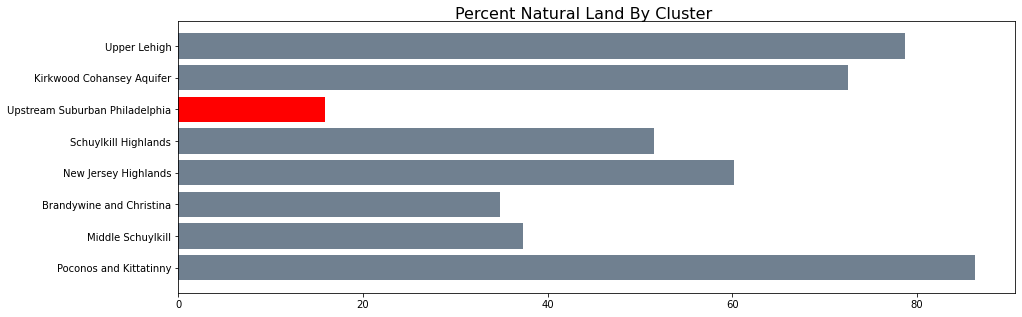

In [21]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
fig.suptitle('Percent Natural Land By Cluster',fontsize=16,y=0.92)

colors = ['red' if i < 30 else 'slategrey' for i in clusterjoin_gdf['perc_natural']]
plt.barh(clusterjoin_gdf['name'], width=clusterjoin_gdf['perc_natural'], color=colors) 
plt.show()

In [22]:
# Get % of natural land in each cluster protected by DRWI projects
clusters = clusterjoin_gdf.index.unique()
clusters = clusters.tolist()

for cluster in clusters:
    # Return cluster area in m2
    geom = clusterjoin_gdf.loc[[cluster]]
    cluster_area = sum(geom.geometry.area)/4046
    cluster_nl_area = sum(geom['natural_area_m2'])/4046
    in_cluster = fielddocjoin_gdf.clip(geom)
    in_cluster_nl = np.nansum(in_cluster['natural_area_m2'])/4046

    perc_natural = in_cluster_nl/cluster_nl_area * 100
    #plt.barh(cluster, width=perc_natural, color='black') 

    #plt.show()

    print(f'Cluster: {cluster} \n   Cluster area: {str(round(cluster_area,2))} \n   Cluster nl area: {str(round(cluster_nl_area,2))} \n   In cluster FD nl area: {str(round(in_cluster_nl,2))} \n   Percent natural DRWI protected: {str(round(perc_natural,2))}')


Cluster: Poconos and Kittatinny 
   Cluster area: 846684.15 
   Cluster nl area: 728472.49 
   In cluster FD nl area: 11025.31 
   Percent natural DRWI protected: 1.51
Cluster: Middle Schuylkill 
   Cluster area: 501982.86 
   Cluster nl area: 186816.43 
   In cluster FD nl area: 0.0 
   Percent natural DRWI protected: 0.0
Cluster: Brandywine and Christina 
   Cluster area: 360600.46 
   Cluster nl area: 125422.3 
   In cluster FD nl area: 0.0 
   Percent natural DRWI protected: 0.0
Cluster: New Jersey Highlands 
   Cluster area: 441887.71 
   Cluster nl area: 265009.21 
   In cluster FD nl area: 745.45 
   Percent natural DRWI protected: 0.28
Cluster: Schuylkill Highlands 
   Cluster area: 109209.72 
   Cluster nl area: 56116.93 
   In cluster FD nl area: 376.98 
   Percent natural DRWI protected: 0.67
Cluster: Upstream Suburban Philadelphia 
   Cluster area: 84674.72 
   Cluster nl area: 13447.14 
   In cluster FD nl area: 0.0 
   Percent natural DRWI protected: 0.0
Cluster: Kirkwood

### Focus Area

In [23]:
focusareas = fajoin_gdf.index.unique()
focusareas = focusareas.tolist()

fa_nl = {'name': [], 'FieldDoc_NaturalLand_m2': [], 'FieldDoc_Area_m2': [],
           'FieldDoc_Area_in_FA_m2': [], 'WCPA_NaturalLand_m2': [], 'WCPA_Area_m2': [],
           'WCPA_Area_in_FA_m2': []}

for fa in focusareas:
    # Return cluster area in m2
    geom = fajoin_gdf.loc[[fa]]
    
    fd_in_fa = fielddocjoin_gdf.clip(geom)
    fd_fa_nl = np.nansum(fd_in_fa['natural_area_m2'])
    fd_area = np.nansum(fd_in_fa['mmw_area_m2'])
    fa_in_fa_area = fd_in_fa.geometry.area.sum()
       
    wcpa_in_fa = wcpajoin_gdf.clip(geom)
    wcpa_in_fa_nl = np.nansum(wcpa_in_fa['natural_area_m2'])
    wcpa_area = (wcpa_in_fa['mmw_area_m2']).sum()
    wcpa_in_fa_area = wcpa_in_fa.geometry.area.sum()
        
    fa_nl['name'].append(fa)
    fa_nl['FieldDoc_NaturalLand_m2'].append(fd_fa_nl)
    fa_nl['FieldDoc_Area_m2'].append(fd_area)
    fa_nl['FieldDoc_Area_in_FA_m2'].append(fa_in_fa_area)
    fa_nl['WCPA_NaturalLand_m2'].append(wcpa_in_fa_nl)
    fa_nl['WCPA_Area_m2'].append(wcpa_area)
    fa_nl['WCPA_Area_in_FA_m2'].append(wcpa_in_fa_area)    
    
fa_nl_df = pd.DataFrame.from_dict(fa_nl)

In [24]:
fajoin_gdf = fajoin_gdf.reset_index()

In [25]:
fajoin_gdf = fajoin_gdf.merge(right=fa_nl_df, left_on='name', right_on='name', how='left')

In [26]:
fajoin_gdf.set_index('name', inplace=True)

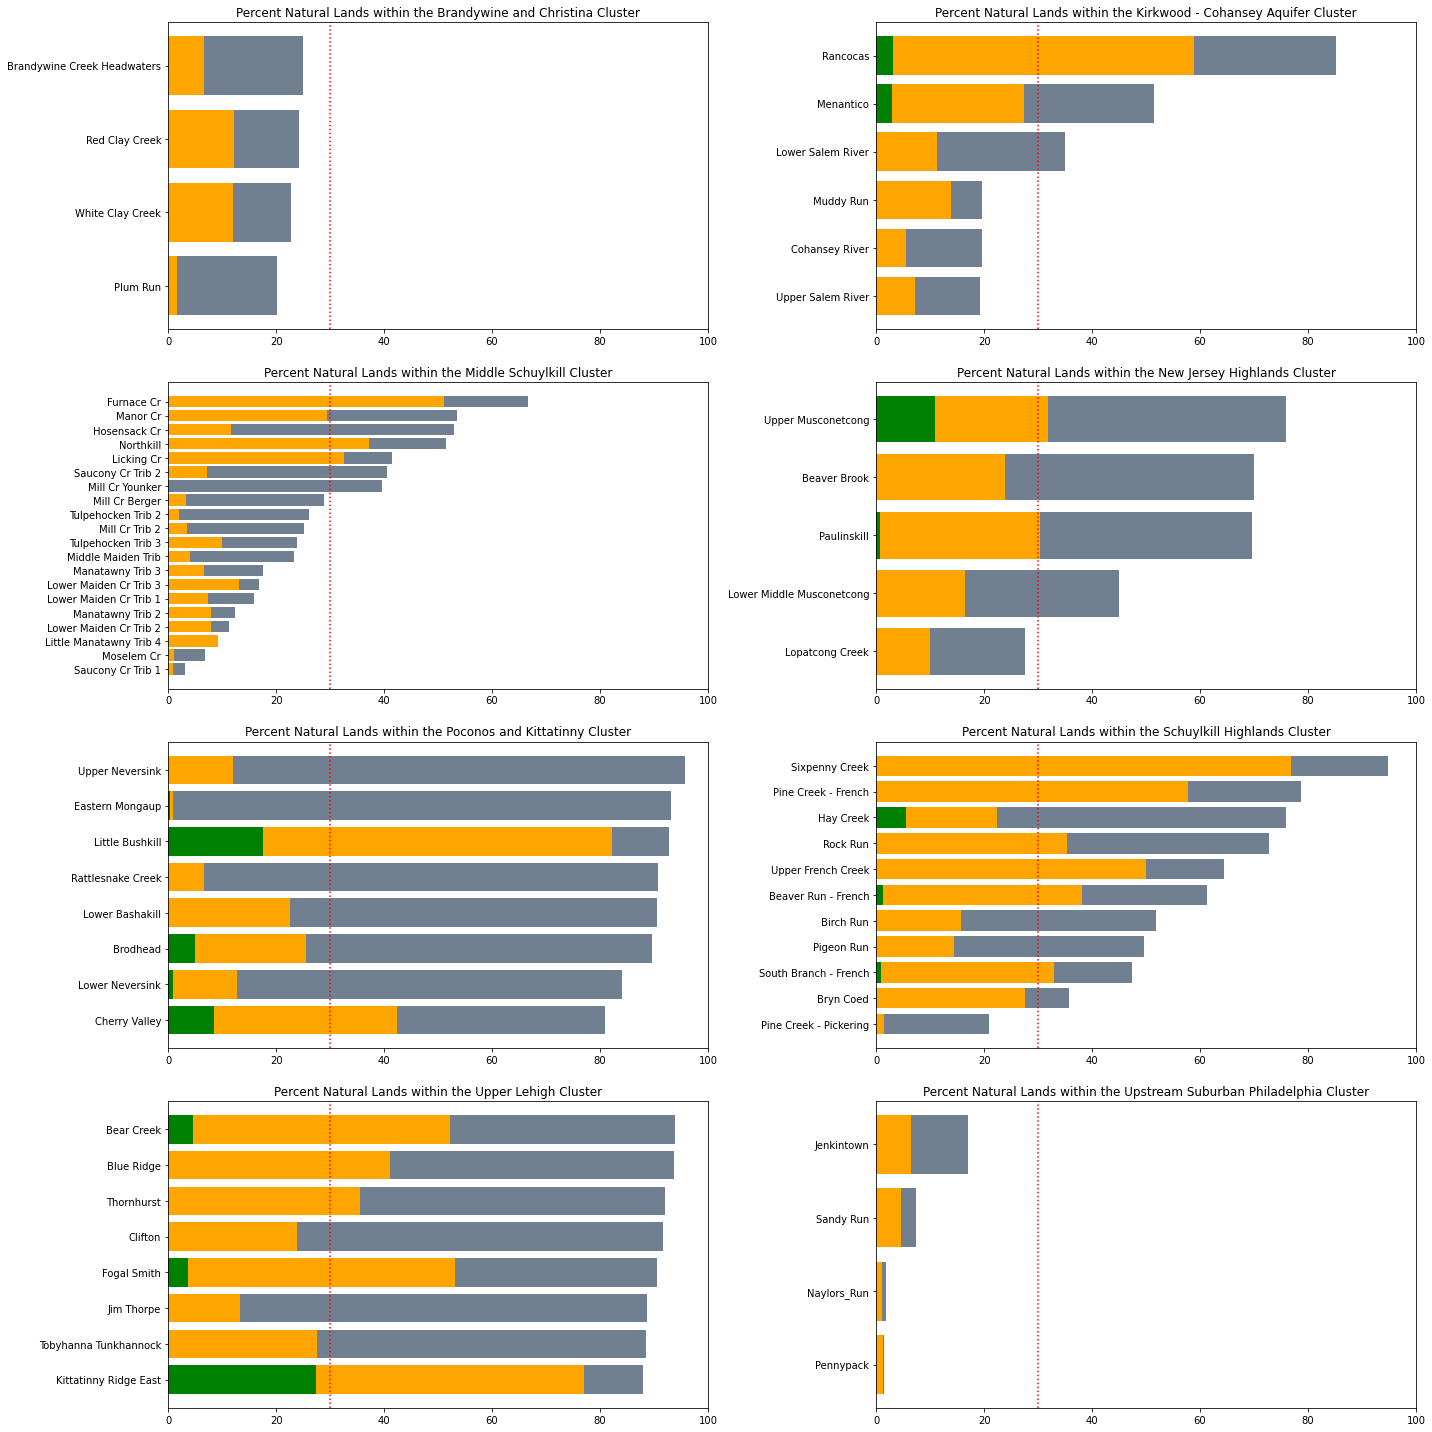

In [27]:
### THESE PLOTS INCLUDE THE DRWI PROTECTED LANDS BUT NOT ALL WCPA LANDS
clusters = fajoin_gdf['cluster'].unique()
clusters = clusters.tolist()

fig, ax = plt.subplots(4,2,figsize=(20,20))
n=1

for cluster in clusters:
    sgdf = fajoin_gdf[fajoin_gdf['cluster'] == cluster]
    focusareas = sgdf.index.unique()

    # Plot
    x = plt.subplot(4,2,n) 
    sorted_sgdf = sgdf.sort_values('perc_natural')
    #colors = ['red' if i < 30 else 'slategrey' for i in sgdf['perc_natural']]
    plt.barh(sorted_sgdf.index, width=sorted_sgdf['perc_natural'], color='slategrey') 

    # Perc natural protected by DRWI
    #plt.barh(sorted_sgdf.index, width=sorted_sgdf['FieldDoc_NaturalLand_m2']/sorted_sgdf['natural_area_m2']*100, color='green')
    fd_width = sorted_sgdf['FieldDoc_NaturalLand_m2']/sorted_sgdf['FieldDoc_Area_m2']*sorted_sgdf['FieldDoc_Area_in_FA_m2']/sorted_sgdf['mmw_area_m2']*100
    fd_width = fd_width.fillna(0)
    plt.barh(sorted_sgdf.index, width=fd_width, color='green')

    # Perc natural protected by WCPA
    # Area in FA computed from geometry and natural lands, WCPA areas, MMW are from what was returned from MMW, so if WCPA MMW runs not complete, this % will potentially inflated
    plt.barh(sorted_sgdf.index, width=(sorted_sgdf['WCPA_NaturalLand_m2']/sorted_sgdf['WCPA_Area_m2']*sorted_sgdf['WCPA_Area_in_FA_m2']/sorted_sgdf['mmw_area_m2'])*100, color='orange',
             left=fd_width)


    plt.axvline(30, color='red', linestyle=':')
    plt.title(f'Percent Natural Lands within the {cluster} Cluster')
    plt.xlim(0,100)

    n = n+1

plt.tight_layout(h_pad=2, w_pad=1)
plt.show()


In [28]:
focusareas = fajoin_gdf.index.unique()
focusareas = focusareas.tolist()

for fa in focusareas:
    # Return cluster area in m2
    geom = fajoin_gdf.loc[[fa]]
    fa_area = sum(geom.geometry.area)/4046
    fa_nl_area = sum(geom['natural_area_m2'])/4046
    in_fa = fielddocjoin_gdf.clip(geom)
    in_fa_nl = np.nansum(in_fa['natural_area_m2'])/4046

    perc_natural = in_fa_nl/fa_nl_area * 100
    #plt.barh(cluster, width=perc_natural, color='black') 

    #plt.show()
    
    if perc_natural > 0:
        print(f'Focus Area: {fa} \n   FA area: {str(round(fa_area,2))} \n   FA nl area: {str(round(fa_nl_area,2))} \n   In FA FieldDoc nl area: {str(round(in_fa_nl,2))} \n   Percent natural DRWI protected: {str(round(perc_natural,2))}')
    else:
        print(f'Focus Area: {fa} not DRWI protected')

Focus Area: Brandywine Creek Headwaters not DRWI protected
Focus Area: Plum Run not DRWI protected
Focus Area: Red Clay Creek not DRWI protected
Focus Area: White Clay Creek not DRWI protected
Focus Area: Cohansey River not DRWI protected
Focus Area: Lower Salem River not DRWI protected
Focus Area: Menantico 
   FA area: 20059.26 
   FA nl area: 10293.05 
   In FA FieldDoc nl area: 579.96 
   Percent natural DRWI protected: 5.63
Focus Area: Muddy Run not DRWI protected
Focus Area: Rancocas 
   FA area: 61809.61 
   FA nl area: 52456.8 
   In FA FieldDoc nl area: 2718.63 
   Percent natural DRWI protected: 5.18
Focus Area: Upper Salem River not DRWI protected
Focus Area: Furnace Cr not DRWI protected
Focus Area: Hosensack Cr not DRWI protected
Focus Area: Licking Cr not DRWI protected
Focus Area: Lower Maiden Cr Trib 1 not DRWI protected
Focus Area: Lower Maiden Cr Trib 3 not DRWI protected
Focus Area: Manatawny Trib 2 not DRWI protected
Focus Area: Manatawny Trib 3 not DRWI protected
F

### Focus Area >30%

In [31]:
# Determine protected area by individual protected land category
fa_list = fajoin_gdf.index.unique()

fa_nl = {'name': [], 'WCPA_NaturalLand_m2_cat': [], 'WCPA_Area_m2_cat': [],
         'WCPA_Area_in_FA_m2_cat': [], 'protectedland_cat': []}

for fa in fa_list:
    ptypes = wcpajoin_gdf['RECLASS2'].unique()
    
    for ptype in ptypes: 
     
        subwcpa_gdf = wcpajoin_gdf[wcpajoin_gdf['RECLASS2']==ptype]
        
        geom = fajoin_gdf.loc[[fa]]

        wcpa_in_fa = subwcpa_gdf.clip(geom)
        wcpa_in_fa_nl = np.nansum(wcpa_in_fa['natural_area_m2'])
        wcpa_area = (wcpa_in_fa['mmw_area_m2']).sum()
        wcpa_in_fa_area = wcpa_in_fa.geometry.area.sum()
  
        fa_nl['name'].append(fa)
        fa_nl['WCPA_NaturalLand_m2_cat'].append(wcpa_in_fa_nl)
        fa_nl['WCPA_Area_m2_cat'].append(wcpa_area)
        fa_nl['WCPA_Area_in_FA_m2_cat'].append(wcpa_in_fa_area)
        fa_nl['protectedland_cat'].append(ptype)
        
fa_nl_cat = pd.DataFrame().from_dict(fa_nl)

In [32]:
fajoin_gdf = fajoin_gdf.reset_index()
fajoin_gdf = fajoin_gdf.merge(fa_nl_cat, left_on='name', right_on='name')

In [33]:
meets_3030_gdf = fajoin_gdf[fajoin_gdf['perc_natural']>30]

In [34]:
meets_3030_gdf['protectedland_cat'].unique()

array(['Agricultural Easement', 'Conservation Easement',
       'Park or Recreation Area - Federal',
       'Natural Resource Area - Federal', 'Natural Resource Area - Local',
       'Park or Recreation Area - Local',
       'Natural Resource Area - Private',
       'Park or Recreation Area - Private',
       'Park or Recreation Area - State', 'Natural Resource Area - State'],
      dtype=object)

In [38]:
meets_3030_gdf = meets_3030_gdf.astype({'protectedland_cat': 'category'})

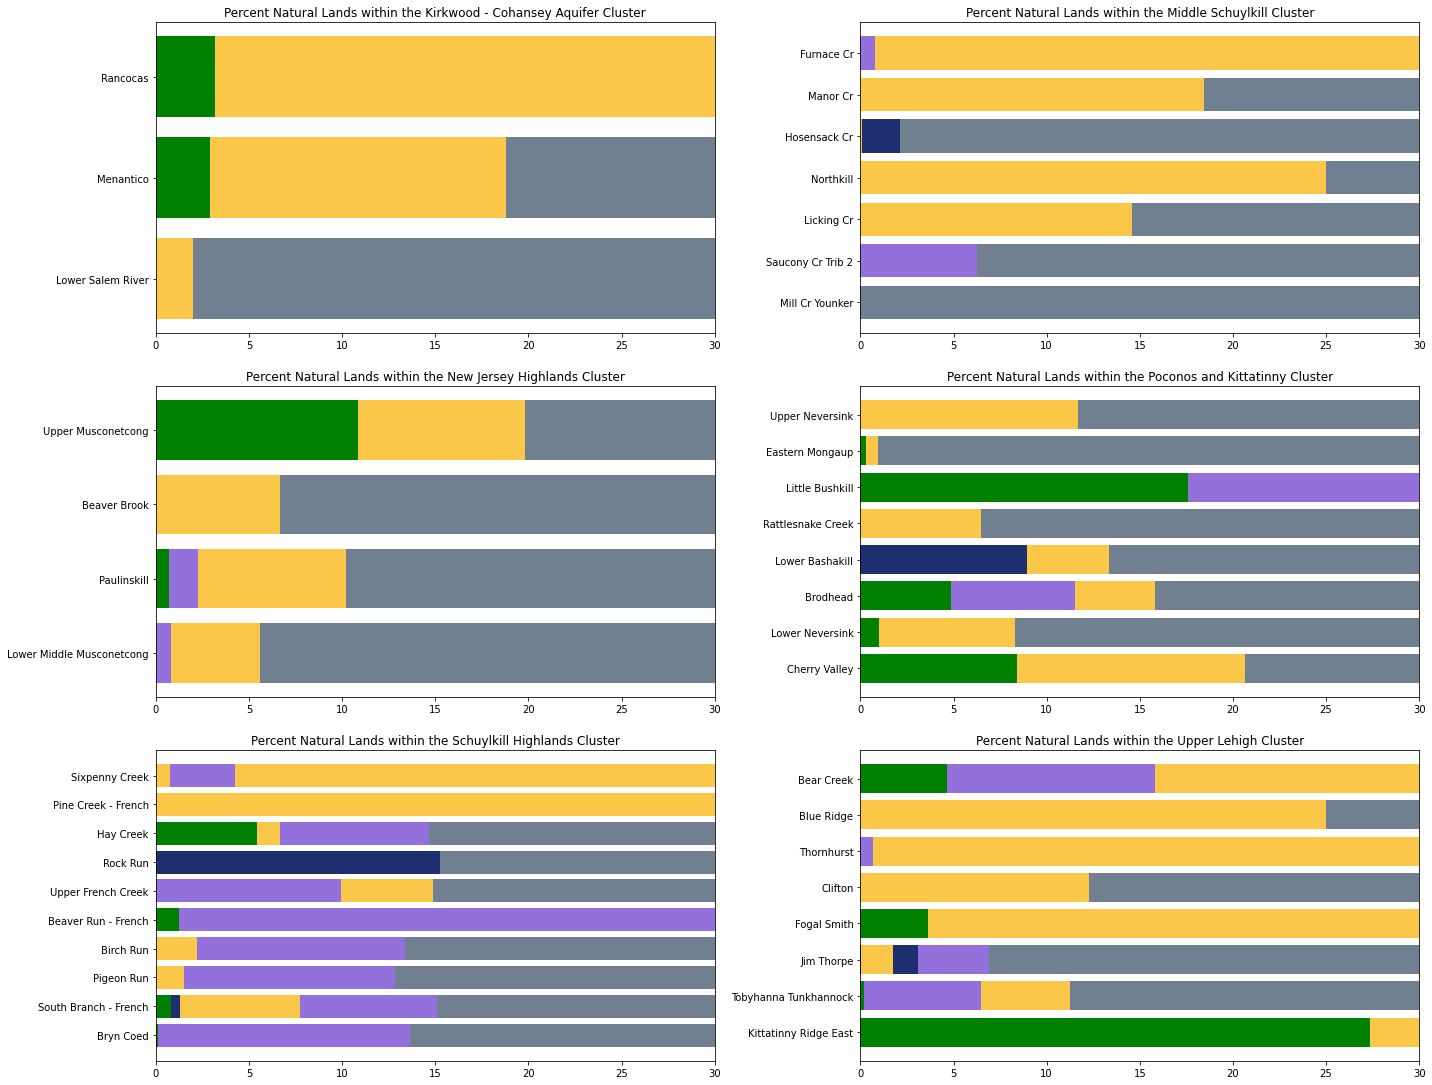

In [41]:
### THESE PLOTS INCLUDE DRWI PROTECTED LANDS BUT NOT ALL WCPA
clusters = meets_3030_gdf['cluster'].unique()
clusters = clusters.tolist()

fig, ax = plt.subplots(3,2,figsize=(20,20))
n=1

for cluster in clusters:
    sgdf = meets_3030_gdf[meets_3030_gdf['cluster'] == cluster]
    noag = sgdf[sgdf['protectedland_cat'] != 'Agricultural Easement']

    # Plot
    x = plt.subplot(4,2,n) 
    sorted_sgdf = noag.sort_values('perc_natural')
    #colors = ['red' if i < 30 else 'slategrey' for i in sgdf['perc_natural']]
    plt.barh(sorted_sgdf.name, width=sorted_sgdf['perc_natural'], color='slategrey') 
    
    # Perc natural protected by DRWI
    fd_width = sorted_sgdf['FieldDoc_NaturalLand_m2']/sorted_sgdf['FieldDoc_Area_m2']*sorted_sgdf['FieldDoc_Area_in_FA_m2']/sorted_sgdf['mmw_area_m2']*100
    fd_width = fd_width.fillna(0)
    plt.barh(sorted_sgdf.name, width=fd_width, color='green', label='DRWI')

    # Perc natural protected by WCPA
    # Area in FA computed from geometry and natural lands, WCPA areas, MMW are from what was returned from MMW, so if WCPA MMW runs not complete, this % will potentially inflated
    width = ((sorted_sgdf['WCPA_NaturalLand_m2_cat']/sorted_sgdf['WCPA_Area_m2_cat']*sorted_sgdf['WCPA_Area_in_FA_m2_cat']/sorted_sgdf['mmw_area_m2'])*100).fillna(0)
    colors = []
    for i in sorted_sgdf['protectedland_cat']:
        if 'Conservation' in i:
            colors.append('mediumpurple')
        if 'Agricultural' in i:
            colors.append('#8390FA')
        if 'Park' in i:
            colors.append('#1D2F6F')
        if 'Natural' in i: 
            colors.append('#FAC748')
    
    plt.barh(sorted_sgdf['name'], width=width, left=fd_width, color=colors, label=sorted_sgdf['protectedland_cat'])
    
    plt.title(f'Percent Natural Lands within the {cluster} Cluster')
    plt.xlim(0,30)
    
    n = n+1

#plt.legend(labels, bbox_to_anchor=([0.58, 1, 0, 0]), ncol=6, frameon=False)
#plt.legend()
plt.tight_layout(h_pad=2, w_pad=1)
plt.show()

## Maps

### Clusters

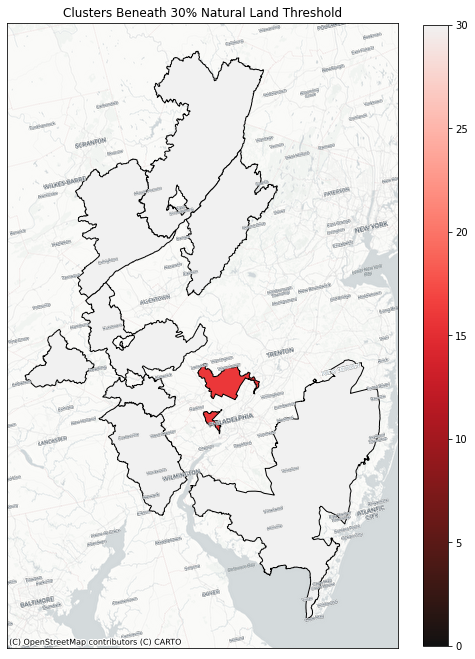

In [42]:
fig, ax1 = plt.subplots(figsize=(7,15))
plt.title('Clusters Beneath 30% Natural Land Threshold')
    
# Add streamreaches to plot
#reach_gdf = reach_gdf.to_crs(pl_gdf.crs.to_string())
#major_streams = reach_gdf[reach_gdf['streamorder'] >= 3].loc[:,('streamorder', 'geom')] 
#rch = major_streams.plot(linewidth=(major_streams['streamorder'] - 1) / 2 , ax=ax1, color='cornflowerblue')

lon_max, lon_min, lat_max, lat_min, area, h_v = LatLonExtent_FA(list(clusterjoin_gdf.index), clusterjoin_gdf)

min_nl = 0
max_nl = 30

# normalize around target with MidPointLogNorm
norm = matplotlib.colors.Normalize(vmin=min_nl, vmax=max_nl)

# Add protected lands to plot
clusterjoin_gdf.plot(column='perc_natural',ax=ax1, cmap='cet_CET_CBTL4', norm=norm, edgecolor='black')

# Turn off ticks
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

# Add colorbar
cax = fig.add_axes([0.95, 0.215, 0.05, 0.575])
sm = plt.cm.ScalarMappable(cmap='cet_CET_CBTL4', 
                           norm=norm)
cbr = fig.colorbar(sm, cax=cax,)
cbr.ax.tick_params(labelsize=10)
cbr.ax.minorticks_off()


# Add basemap to plot
if area < 7:
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=clusterjoin_gdf.crs.to_string(), zoom=10, interpolation='sinc')
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=clusterjoin_gdf.crs.to_string(), zoom=10, zorder=2, interpolation='sinc')
else:
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=clusterjoin_gdf.crs.to_string(), zoom=9, interpolation='sinc')
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=clusterjoin_gdf.crs.to_string(), zoom=9, zorder=2, interpolation='sinc')


### Focus Areas

ValueError: Axis limits cannot be NaN or Inf

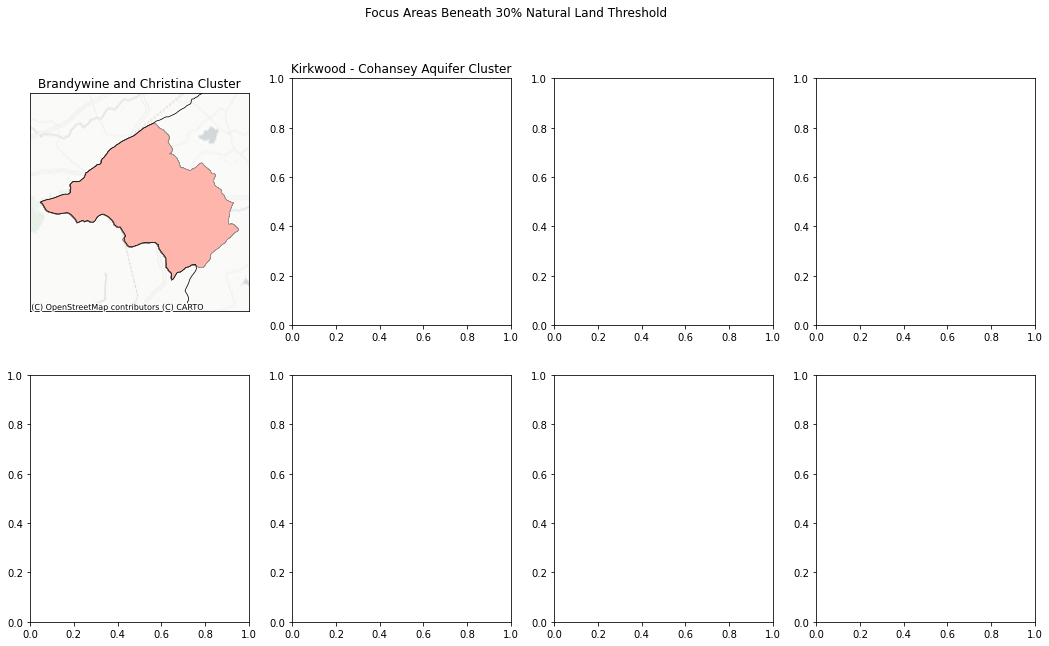

In [43]:
clusters = fajoin_gdf['cluster'].unique()
clusters = clusters.tolist()
n=1

#for cluster in clusters:
cluster = 'Brandywine and Christina'

fig, ax1 = plt.subplots(2,4, figsize=(18,10))
plt.suptitle('Focus Areas Beneath 30% Natural Land Threshold')

    
for cluster in clusters:    
    sgdf = fajoin_gdf[fajoin_gdf['cluster'] == cluster]
    ax1 = plt.subplot(2,4,n)
    plt.title(f'{cluster} Cluster')

    lon_max, lon_min, lat_max, lat_min, area, h_v = LatLonExtent_FA(list(sgdf.index), sgdf)
    FormatAxes(ax1, bounds=[lon_min, lon_max, lat_min, lat_max])

    # normalize around target 
    min_nl = 0
    max_nl = 30
    norm = matplotlib.colors.Normalize(vmin=min_nl, vmax=max_nl)
    
    # Add protected lands to plot
    fajoin_gdf.plot(column='perc_natural',ax=ax1, cmap='cet_CET_CBTL4', norm=norm, edgecolor='grey', lw=0.5)
    clusterjoin_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', lw=0.75)

    # Turn off ticks
    plt.tick_params(axis='x', bottom=False, labelbottom=False)
    plt.tick_params(axis='y', left=False, labelleft=False)

    # Add basemap to plot
    if area < 0.05:
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=fajoin_gdf.crs.to_string(), zoom=13, interpolation='sinc')
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=fajoin_gdf.crs.to_string(), zoom=13, zorder=2, interpolation='sinc')
    elif area < 1:
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=fajoin_gdf.crs.to_string(), zoom=11, interpolation='sinc')
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=fajoin_gdf.crs.to_string(), zoom=11, zorder=2, interpolation='sinc')
    elif area < 4:
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=fajoin_gdf.crs.to_string(), zoom=10, interpolation='sinc')        
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=fajoin_gdf.crs.to_string(), zoom=10, zorder=2, interpolation='sinc')
    else:
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=fajoin_gdf.crs.to_string(), zoom=9, interpolation='sinc')        
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=fajoin_gdf.crs.to_string(), zoom=9, zorder=2, interpolation='sinc')
        
    n=n+1

plt.tight_layout()


x0, y0, width, height =[1.2, 0.2, 0.1, 1.5]

Bbox = matplotlib.transforms.Bbox.from_bounds(x0, y0, width, height)
trans = ax1.transAxes + fig.transFigure.inverted()
l, b, w, h = matplotlib.transforms.TransformedBbox(Bbox, trans).bounds


# Add colorbar
cax = fig.add_axes([l, b, w, h])
sm = plt.cm.ScalarMappable(cmap='cet_CET_CBTL4', 
                           norm=norm)
cbr = fig.colorbar(sm, cax=cax,)
cbr.ax.tick_params(labelsize=10)
cbr.ax.minorticks_off()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7,15))
plt.title('Focus Areas Beneath 30% Natural Land Threshold')
    
# Add streamreaches to plot
#reach_gdf = reach_gdf.to_crs(pl_gdf.crs.to_string())
#major_streams = reach_gdf[reach_gdf['streamorder'] >= 3].loc[:,('streamorder', 'geom')] 
#rch = major_streams.plot(linewidth=(major_streams['streamorder'] - 1) / 2 , ax=ax1, color='cornflowerblue')

lon_max, lon_min, lat_max, lat_min, area, h_v = LatLonExtent_FA(list(fajoin_gdf.index), fajoin_gdf)

min_nl = 0
max_nl = 30

# normalize around target with MidPointLogNorm
norm = matplotlib.colors.Normalize(vmin=min_nl, vmax=max_nl)

# Add protected lands to plot
fajoin_gdf.plot(column='perc_natural',ax=ax1, cmap='cet_CET_CBTL4', norm=norm, edgecolor='grey', lw=0.5)
clusterjoin_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', lw=0.75)


# Turn off ticks
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

# Add colorbar
cax = fig.add_axes([0.95, 0.215, 0.05, 0.575])
sm = plt.cm.ScalarMappable(cmap='cet_CET_CBTL4', 
                           norm=norm)
cbr = fig.colorbar(sm, cax=cax,)
cbr.ax.tick_params(labelsize=10)
cbr.ax.minorticks_off()


# Add basemap to plot
if area < 0.05:
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=fajoin_gdf.crs.to_string(), zoom=13, interpolation='sinc')
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=fajoin_gdf.crs.to_string(), zoom=13, zorder=2, interpolation='sinc')
elif area < 1:
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=fajoin_gdf.crs.to_string(), zoom=11, interpolation='sinc')
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=fajoin_gdf.crs.to_string(), zoom=11, zorder=2, interpolation='sinc')
elif area < 4:
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=fajoin_gdf.crs.to_string(), zoom=10, interpolation='sinc')        
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=fajoin_gdf.crs.to_string(), zoom=10, zorder=2, interpolation='sinc')
else:
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=fajoin_gdf.crs.to_string(), zoom=9, interpolation='sinc')        
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=fajoin_gdf.crs.to_string(), zoom=9, zorder=2, interpolation='sinc')
